# Introduction to Linear Regression Analysis

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# for jupyter plot visualization
% matplotlib inline
# filtering out warnings 
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
warnings.filterwarnings(action="ignore", module="sklearn", message="^max_iter")
warnings.filterwarnings(action="ignore", module="sklearn", message="^Maximum")

# data import
df = pd.read_csv('2017-11-21_230246.csv')
stats_df = df.drop(['city', 'state', 'zip'], 1)
stats_df = stats_df.dropna()
df = df.dropna()
df = df.drop('state', 1)

## Summary Statistics

In [2]:
summary_df = pd.concat([stats_df.describe().T, stats_df.median(), stats_df.mode().iloc[0], stats_df.var()], axis=1)
summary_df.columns = ['Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max', 'Median', 'Mode', 'Variance']
summary_df

,Count,Mean,Std,Min,25%,50%,75%,Max,Median,Mode,Variance
price,3854.0,2.904184e+06,6.325874e+06,9900.00,655000.00,1300000.0,2799749.25,180000000.0,1300000.0,799000.0,4.001669e+13
sqft,3854.0,2.869577e+03,2.740097e+03,110.00,1367.25,2072.0,3500.00,51000.0,2072.0,1200.0,7.508132e+06
bedrooms,3854.0,3.774520e+00,2.428690e+00,0.00,2.00,3.0,4.00,48.0,3.0,3.0,5.898536e+00
bathrooms,3854.0,3.503762e+00,2.725417e+00,0.75,2.00,3.0,4.00,48.0,3.0,2.0,7.427899e+00


## Finding Outliers Outside of 3 Standard Deviations, and Noting it

In [3]:
df_sans_outliers = stats_df[(np.abs(stats.zscore(stats_df)) < 3).all(axis=1)]
outliers = stats_df[(np.abs(stats.zscore(stats_df)) > 3).all(axis=1)]
outlier_df = df[df['price'] == int(outliers.price)]
outlier_df

,city,zip,price,sqft,bedrooms,bathrooms
3928,Los Angeles,90077,90000000.0,31000.0,12.0,24.0


## Scatter Plot Matrix

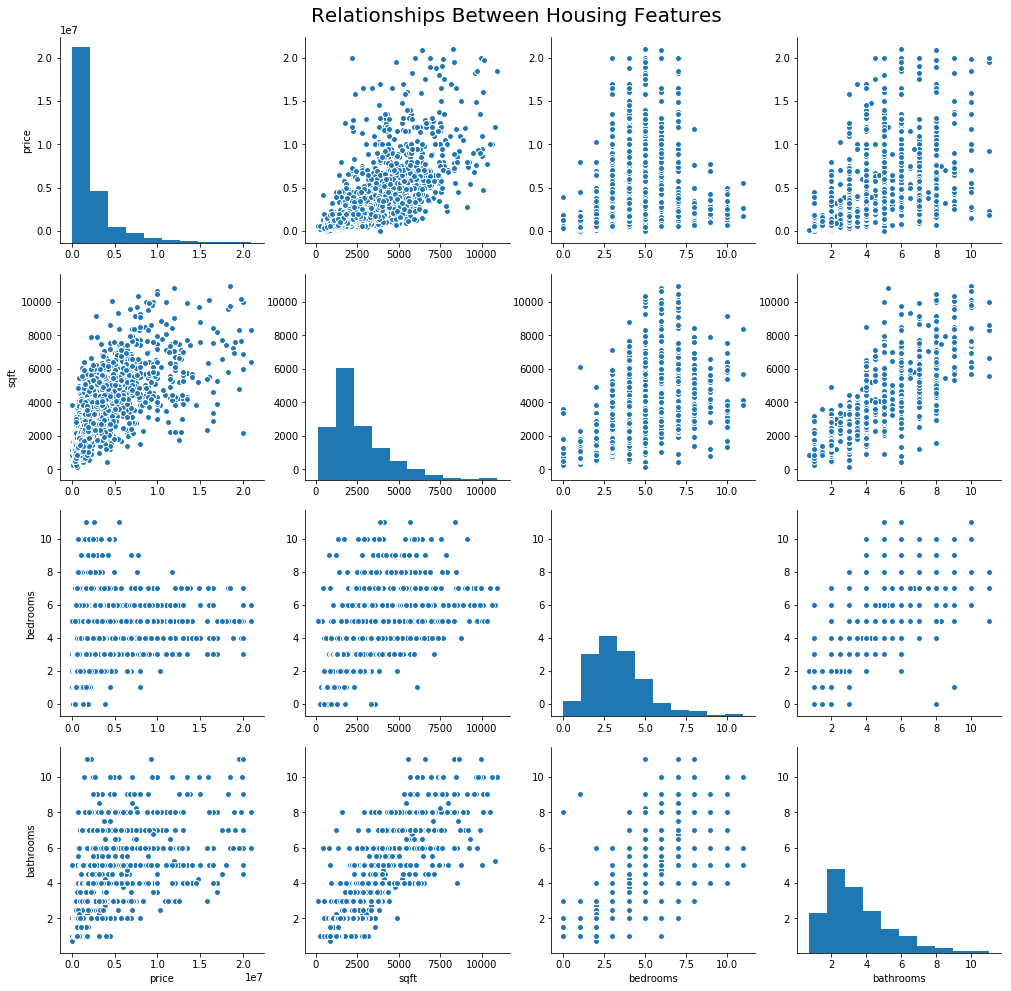

In [4]:
g = sns.pairplot(df_sans_outliers, size=3.5)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Relationships Between Housing Features', size=20)
plt.show()

## Correlation Mapping

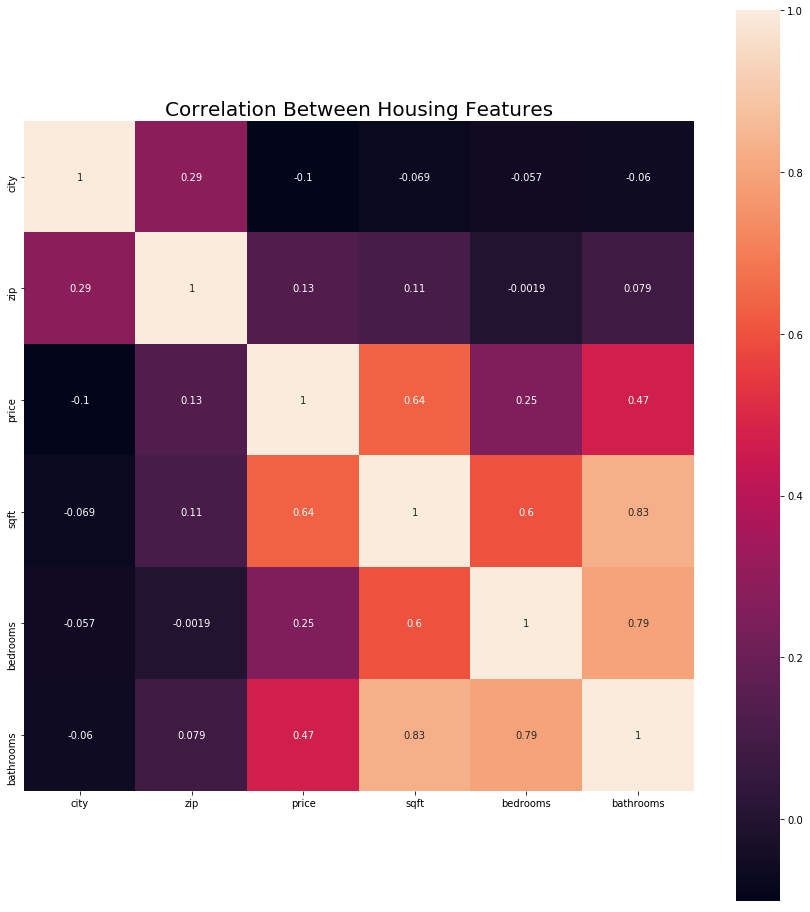

In [5]:
le = LabelEncoder()
df['city'] = le.fit_transform(df['city'])
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df.corr(), annot=True, square=True, ax=ax).set_title('Correlation Between Housing Features', size=20)
plt.subplots_adjust(top=0.95)
plt.show()

## Correlation Coefficients Ranked

In [6]:
# subtracting the outliers from the training dataset
training_df = df[~(df['price'] == int(outlier_df['price']))]
training_df.corr()['price'].sort_values(ascending=False).iloc[1:]

sqft         0.622805
bathrooms    0.454742
bedrooms     0.247506
zip          0.132020
city        -0.103444
Name: price, dtype: float64

## ML and Model Optimization

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

In [8]:
# creating grid search cv parameters for brute force parameter searching
sgd = GridSearchCV(SGDRegressor(), param_grid={
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['none', 'l2', 'l1', 'elasticnet'],
    'max_iter': [10000],
    'tol': [1e-3]
}, return_train_score=True, scoring='neg_mean_squared_error')
lr = GridSearchCV(LinearRegression(), param_grid={
    'fit_intercept': [True, False],
    'normalize': [True, False]
}, return_train_score=True, scoring='neg_mean_squared_error')

# defining the independent and dependent variables
X = training_df.drop('price', 1)
y = training_df['price']

# Manually selecting most important features
three_feature_df = X[['sqft', 'bathrooms', 'bedrooms']]
two_feature_df = X[['sqft', 'bathrooms']]
one_feature_df = X['sqft'].values.reshape(-1, 1)

# Using SelectKBest to get the most important features
# three_feature_df = SelectKBest(chi2, k=3).fit_transform(X, y)
# two_feature_df = SelectKBest(chi2, k=2).fit_transform(X, y)
# one_feature_df = SelectKBest(chi2, k=1).fit_transform(X, y)

# Iterating through the dataframes containing 1, 2, and 3 features
MSE_ranking_dict = {}
for x, name in zip([X, three_feature_df, two_feature_df, one_feature_df], ['all', 'one', 'two', 'three']):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)
    
    # fitting the GridSearchCV pipelines
    lr.fit(x, y)
    sgd.fit(x, y)
    
    # fitting the best estimators of each grid search
    lr.best_estimator_.fit(X_train, y_train)
    sgd.best_estimator_.fit(X_train, y_train)
    
    # assigning keys and values for display  
    lr_key = f"Linear Regression MSE using {name} features"
    lr_value = mean_squared_error(y_test, lr.best_estimator_.predict(X_test))
    sgd_key = f"Stochastic Gradient Descent MSE using {name} features"
    sgd_value = mean_squared_error(y_test, sgd.best_estimator_.predict(X_test))
    MSE_ranking_dict[sgd_key] = sgd_value
    MSE_ranking_dict[lr_key] = lr_value

# displaying and sorting the MSEs of each model/feature combination
MSE_diplay_df = pd.DataFrame.from_dict(MSE_ranking_dict, orient='index')
MSE_diplay_df.columns = ['MSE']
MSE_diplay_df.sort_values('MSE')

,MSE
Linear Regression MSE using all features,2.170306e+13
Linear Regression MSE using one features,2.194824e+13
Linear Regression MSE using two features,2.385291e+13
Linear Regression MSE using three features,2.475391e+13
Stochastic Gradient Descent MSE using all features,3.016970e+13
Stochastic Gradient Descent MSE using two features,3.384046e+13
Stochastic Gradient Descent MSE using one features,3.450095e+13
Stochastic Gradient Descent MSE using three features,3.501579e+13
